In [1]:
from datasets import load_dataset

dataset = load_dataset("dnth/active-learning-imagenette")

dataset

DatasetDict({
    evaluation: Dataset({
        features: ['image', 'filepath', 'label_name'],
        num_rows: 3925
    })
    unlabeled: Dataset({
        features: ['image', 'filepath', 'label_name'],
        num_rows: 9469
    })
})

In [2]:
dataset["unlabeled"]

Dataset({
    features: ['image', 'filepath', 'label_name'],
    num_rows: 9469
})

In [3]:
import numpy as np

unique_labels = dataset["unlabeled"].unique("label_name")
samples = []
n_samples_per_class = 10

for label in unique_labels:
    label_indices = np.where(np.array(dataset["unlabeled"]["label_name"]) == label)[0]
    # Sample 10 random indices without replacement
    random_indices = np.random.choice(
        label_indices, size=n_samples_per_class, replace=False
    )
    samples.extend(random_indices)

initial_samples = dataset["unlabeled"].select(samples)

# Verify the result (should show 100 rows total, 10 per class)
print(f"Total samples: {len(initial_samples)}")
print("\nSamples per class:")
print(initial_samples.select_columns(["label_name"]).to_pandas().value_counts())

Total samples: 100

Samples per class:
label_name      
English springer    10
French horn         10
cassette player     10
chain saw           10
church              10
garbage truck       10
gas pump            10
golf ball           10
parachute           10
tench               10
Name: count, dtype: int64


In [4]:
initial_samples = initial_samples.remove_columns("image")

df = initial_samples.to_pandas()

df

,filepath,label_name
0,data/imagenette/2/00346.jpg,cassette player
1,data/imagenette/2/00845.jpg,cassette player
2,data/imagenette/2/00383.jpg,cassette player
3,data/imagenette/2/00503.jpg,cassette player
4,data/imagenette/2/00002.jpg,cassette player
...,...,...
95,data/imagenette/5/09030.jpg,French horn
96,data/imagenette/5/09299.jpg,French horn
97,data/imagenette/5/09018.jpg,French horn
98,data/imagenette/5/08529.jpg,French horn


In [21]:
df.to_parquet("training_samples.parquet")

## Train a model on the initial samples

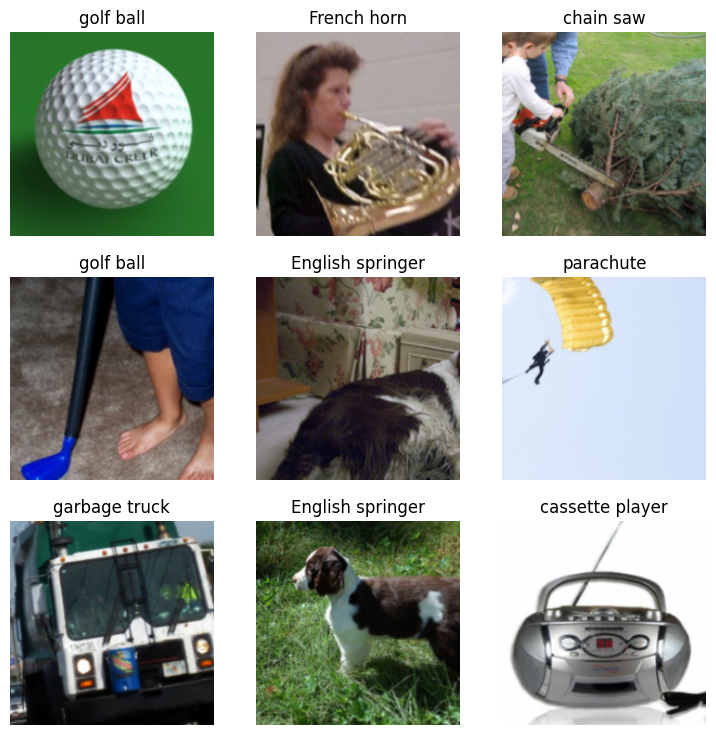

In [5]:
from fastai.vision.all import *

base_path = "."
dls = ImageDataLoaders.from_df(
    df,
    path=base_path,
    valid_pct=0.2,
    fn_col="filepath",
    label_col="label_name",
    bs=16,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

dls.show_batch()

/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, m

SuggestedLRs(valley=0.001737800776027143, slide=0.0010000000474974513)

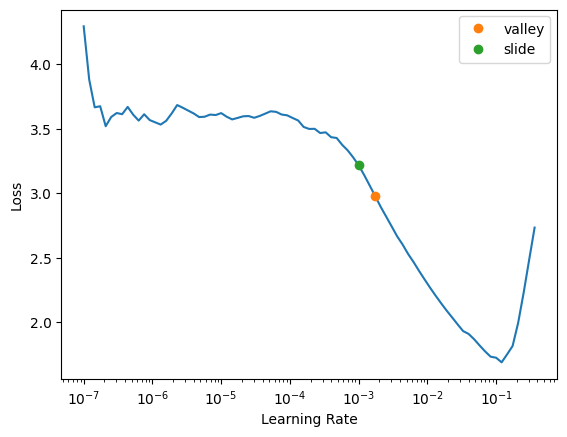

In [6]:
learn = vision_learner(dls, resnet18, metrics=accuracy).to_fp16()
learn.lr_find(suggest_funcs=(valley, slide))

epoch,train_loss,valid_loss,accuracy,time
0,3.580036,2.417390,0.150000,00:01


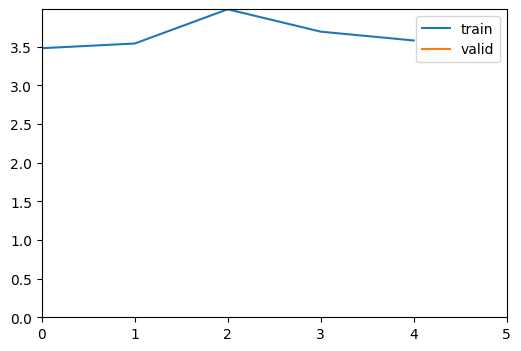

epoch,train_loss,valid_loss,accuracy,time
0,2.985927,1.570532,0.400000,00:01
1,2.506132,0.975099,0.750000,00:01
2,2.076184,0.565676,0.850000,00:01
3,1.761045,0.356547,0.900000,00:01
4,1.449406,0.285929,0.950000,00:01
5,1.196610,0.278147,0.900000,00:01
6,1.010450,0.257685,0.900000,00:01
7,0.876771,0.251697,0.900000,00:01
8,0.758832,0.259004,0.900000,00:01
9,0.672445,0.252126,0.900000,00:01


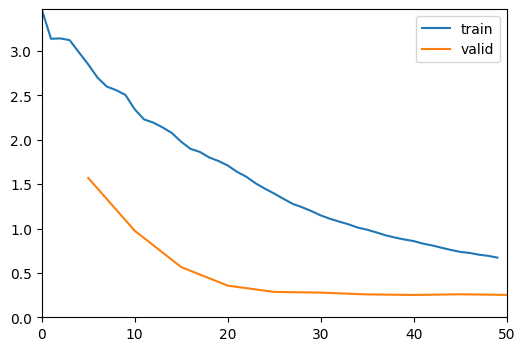

In [7]:
learn.fine_tune(10, 1e-3, cbs=[ShowGraphCallback()])

## Evaluate the model on the validation set

In [23]:
eval_df = dataset["evaluation"].remove_columns("image").to_pandas()

eval_df


,filepath,label_name
0,data/imagenette/2/00000.jpg,cassette player
1,data/imagenette/2/00001.jpg,cassette player
2,data/imagenette/2/00002.jpg,cassette player
3,data/imagenette/2/00003.jpg,cassette player
4,data/imagenette/2/00004.jpg,cassette player
...,...,...
3920,data/imagenette/5/03920.jpg,French horn
3921,data/imagenette/5/03921.jpg,French horn
3922,data/imagenette/5/03922.jpg,French horn
3923,data/imagenette/5/03923.jpg,French horn


In [24]:
eval_df.to_parquet("evaluation_samples.parquet")

In [9]:
list_of_images = eval_df["filepath"].tolist()

list_of_images


['data/imagenette/2/00000.jpg',
 'data/imagenette/2/00001.jpg',
 'data/imagenette/2/00002.jpg',
 'data/imagenette/2/00003.jpg',
 'data/imagenette/2/00004.jpg',
 'data/imagenette/2/00005.jpg',
 'data/imagenette/2/00006.jpg',
 'data/imagenette/2/00007.jpg',
 'data/imagenette/2/00008.jpg',
 'data/imagenette/2/00009.jpg',
 'data/imagenette/2/00010.jpg',
 'data/imagenette/2/00011.jpg',
 'data/imagenette/2/00012.jpg',
 'data/imagenette/2/00013.jpg',
 'data/imagenette/2/00014.jpg',
 'data/imagenette/2/00015.jpg',
 'data/imagenette/2/00016.jpg',
 'data/imagenette/2/00017.jpg',
 'data/imagenette/2/00018.jpg',
 'data/imagenette/2/00019.jpg',
 'data/imagenette/2/00020.jpg',
 'data/imagenette/2/00021.jpg',
 'data/imagenette/2/00022.jpg',
 'data/imagenette/2/00023.jpg',
 'data/imagenette/2/00024.jpg',
 'data/imagenette/2/00025.jpg',
 'data/imagenette/2/00026.jpg',
 'data/imagenette/2/00027.jpg',
 'data/imagenette/2/00028.jpg',
 'data/imagenette/2/00029.jpg',
 'data/imagenette/2/00030.jpg',
 'data/i

In [10]:
test_dl = dls.test_dl(list_of_images)

preds = learn.get_preds(dl=test_dl, with_decoded=True)
preds


/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


(tensor([[1.4474e-03, 4.0890e-05, 9.9305e-01,  ..., 8.6873e-04, 1.2331e-03,
          1.2136e-04],
         [1.4862e-02, 8.7699e-04, 9.7118e-01,  ..., 1.4889e-03, 4.2609e-03,
          2.7274e-04],
         [1.1848e-05, 1.4824e-05, 9.9987e-01,  ..., 2.3831e-05, 7.9813e-06,
          9.0440e-06],
         ...,
         [6.4501e-05, 9.9765e-01, 8.1469e-04,  ..., 1.2941e-04, 8.0049e-04,
          4.4722e-05],
         [2.0597e-04, 9.9857e-01, 2.6031e-04,  ..., 2.4930e-04, 1.5449e-04,
          1.7948e-04],
         [4.7698e-05, 9.9762e-01, 5.2848e-05,  ..., 3.3230e-04, 5.7422e-05,
          5.8948e-06]]),
 None,
 tensor([2, 2, 2,  ..., 1, 1, 1]))

In [11]:
preds[2]


tensor([2, 2, 2,  ..., 1, 1, 1])

In [12]:
learn.dls.vocab


['English springer', 'French horn', 'cassette player', 'chain saw', 'church', 'garbage truck', 'gas pump', 'golf ball', 'parachute', 'tench']

In [13]:
# Convert tensor to numpy array for easier handling
pred_indices = preds[2].numpy()

# Map indices to class names using the vocabulary
pred_classes = [learn.dls.vocab[idx] for idx in pred_indices]

pred_classes


['cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'church',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassett

In [14]:
eval_df['predicted_label'] = pred_classes

In [15]:
eval_df

,filepath,label_name,predicted_label
0,data/imagenette/2/00000.jpg,cassette player,cassette player
1,data/imagenette/2/00001.jpg,cassette player,cassette player
2,data/imagenette/2/00002.jpg,cassette player,cassette player
3,data/imagenette/2/00003.jpg,cassette player,cassette player
4,data/imagenette/2/00004.jpg,cassette player,cassette player
...,...,...,...
3920,data/imagenette/5/03920.jpg,French horn,French horn
3921,data/imagenette/5/03921.jpg,French horn,French horn
3922,data/imagenette/5/03922.jpg,French horn,French horn
3923,data/imagenette/5/03923.jpg,French horn,French horn


In [16]:
accuracy = (eval_df['label_name'] == eval_df['predicted_label']).mean()
print(f"Overall Accuracy: {accuracy:.2%}")

Overall Accuracy: 91.24%


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

print("\nDetailed Classification Report:")
print(classification_report(eval_df["label_name"], eval_df["predicted_label"]))


Detailed Classification Report:
                  precision    recall  f1-score   support

English springer       0.98      0.96      0.97       395
     French horn       0.92      0.93      0.93       394
 cassette player       0.80      0.94      0.87       357
       chain saw       0.82      0.82      0.82       386
          church       0.93      0.96      0.95       409
   garbage truck       0.95      0.86      0.90       389
        gas pump       0.87      0.83      0.85       419
       golf ball       0.97      0.95      0.96       399
       parachute       0.92      0.93      0.92       390
           tench       0.99      0.95      0.97       387

        accuracy                           0.91      3925
       macro avg       0.91      0.91      0.91      3925
    weighted avg       0.91      0.91      0.91      3925



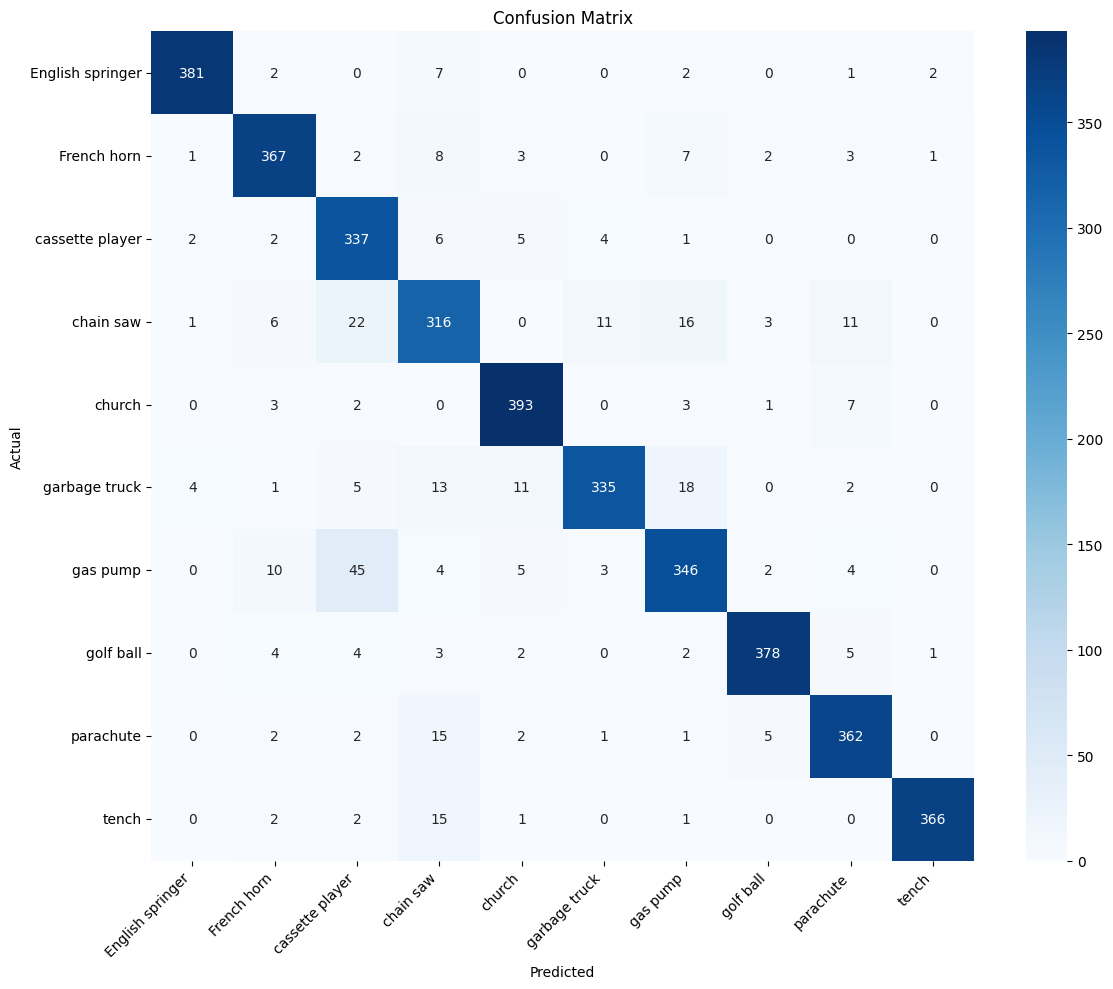

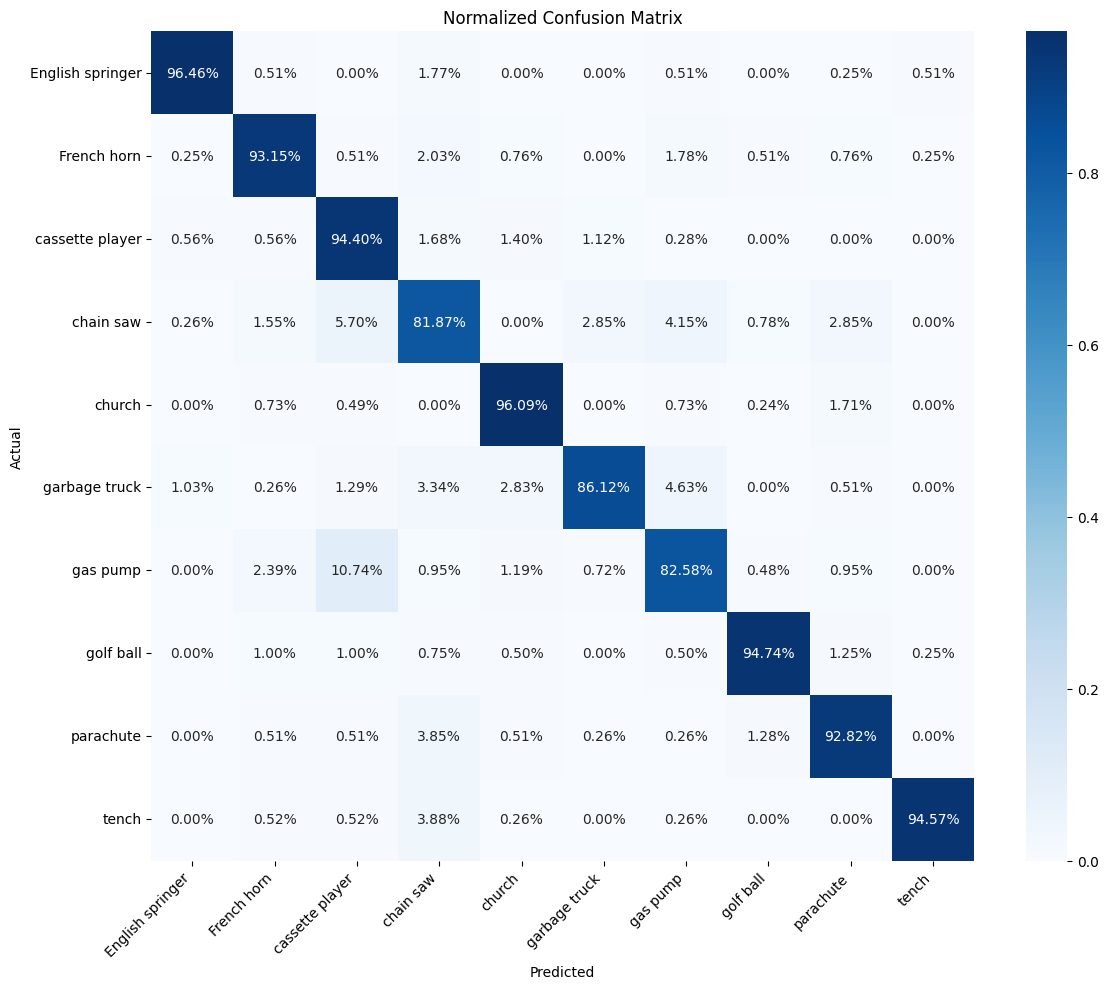

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(eval_df["label_name"], eval_df["predicted_label"])

# Create a figure with larger size
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(
    cm,
    annot=True,  # Show numbers in cells
    fmt="d",  # Format as integer
    cmap="Blues",  # Color scheme
    xticklabels=learn.dls.vocab,
    yticklabels=learn.dls.vocab,
)

# Add labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Calculate and display normalized confusion matrix (percentages)
cm_normalized = confusion_matrix(
    eval_df["label_name"], eval_df["predicted_label"], normalize="true"
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2%",  # Format as percentage
    cmap="Blues",
    xticklabels=learn.dls.vocab,
    yticklabels=learn.dls.vocab,
)

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
learn.export("initial_model.pkl")